In [1]:
import os
import sys
import math
import datetime
import tables            as tb
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from   invisible_cities.io   .mcinfo_io     import read_mcinfo

from invisible_cities.core.exceptions       import SipmEmptyList
from invisible_cities.core.exceptions       import SipmZeroCharge

### Analysis

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.icaro.hst_functions import hist2d
from   invisible_cities.core.core_functions import in_range
from   invisible_cities.icaro.hst_functions import shift_to_bin_centers
from   invisible_cities.reco import tbl_functions as tbl

In [7]:
eventsPath     = '/Users/carmenromoluque/Analysis/scripts_before_dataframes/1_data_r_maps/no_refl_sipms/'
nsteps         = 6
true_r1        = [[] for i in range(0, nsteps)]
true_r2        = [[] for i in range(0, nsteps)]
var_phi1       = [[] for i in range(0, nsteps)]
var_phi2       = [[] for i in range(0, nsteps)]
sigma_phi1     = [[] for i in range(0, nsteps)]
sigma_phi2     = [[] for i in range(0, nsteps)]
touched_sipms1 = [[] for i in range(0, nsteps)]
touched_sipms2 = [[] for i in range(0, nsteps)]

for filename in os.listdir(eventsPath):
    if filename.endswith('.npz'):
        my_file   = eventsPath+filename
        d = np.load(my_file)

        for i in range(nsteps):
            try:
                variable_name = 'a_true_r1_{}'.format(i)
                true_r1       [i] = np.concatenate((true_r1       [i], d[variable_name]))
                variable_name = 'a_true_r2_{}'.format(i)
                true_r2       [i] = np.concatenate((true_r2       [i], d[variable_name]))
                variable_name = 'a_var_phi1_{}'.format(i)
                var_phi1      [i] = np.concatenate((var_phi1      [i], d[variable_name]))
                variable_name = 'a_var_phi2_{}'.format(i)
                var_phi2      [i] = np.concatenate((var_phi2      [i], d[variable_name]))
                variable_name = 'a_touched_sipms1_{}'.format(i)
                touched_sipms1[i] = np.concatenate((touched_sipms1[i], d[variable_name]))
                variable_name = 'a_touched_sipms2_{}'.format(i)
                touched_sipms2[i] = np.concatenate((touched_sipms2[i], d[variable_name]))
                           
            except:
                continue
for i in range(nsteps):
    sel1 = (true_r1[i] < 1.e9)
    sel2 = (true_r2[i] < 1.e9)
    
    true_r1   [i] = np.array(true_r1 [i][sel1])
    true_r2   [i] = np.array(true_r2 [i][sel2])
    var_phi1  [i] = np.array(var_phi1[i][sel1])
    var_phi2  [i] = np.array(var_phi2[i][sel2])
    sigma_phi1[i] = np.sqrt(var_phi1 [i])
    sigma_phi2[i] = np.sqrt(var_phi2 [i])

In [8]:
len(true_r1[0])/500

1097.97

In [9]:
# Plotting style
default_cmap = "jet"
figure_size  = 12.5, 12.5
font_size    = 15

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

## style
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
blue         = tableau20[ 0]
green        = tableau20[ 4]
red          = tableau20[ 6]
pink         = tableau20[ 7]
purple       = tableau20[ 8]
light_purple = tableau20[ 9]
brown        = tableau20[10]
grey         = tableau20[15]

plt.rcParams["font.size"     ] = 15
plt.rcParams["figure.figsize"] = 12, 8

<Figure size 576x576 with 0 Axes>

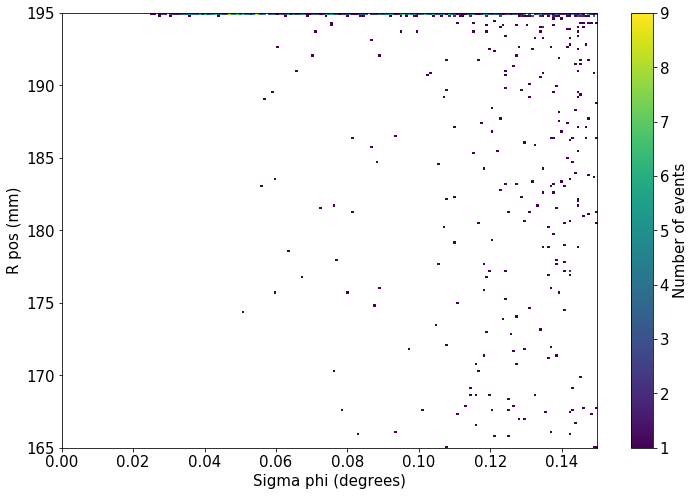

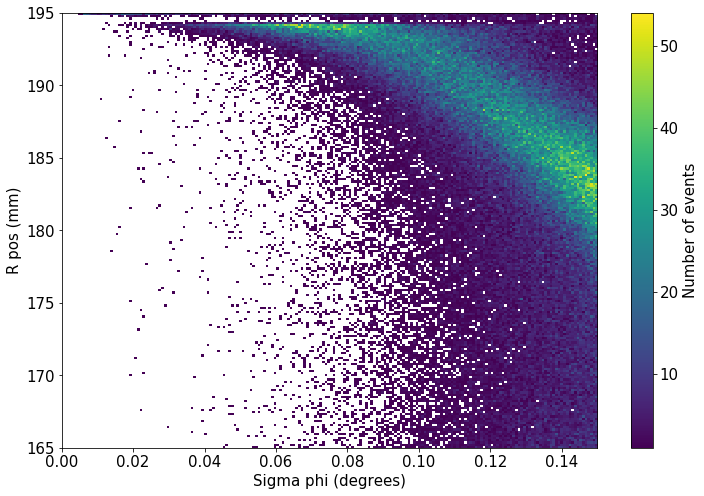

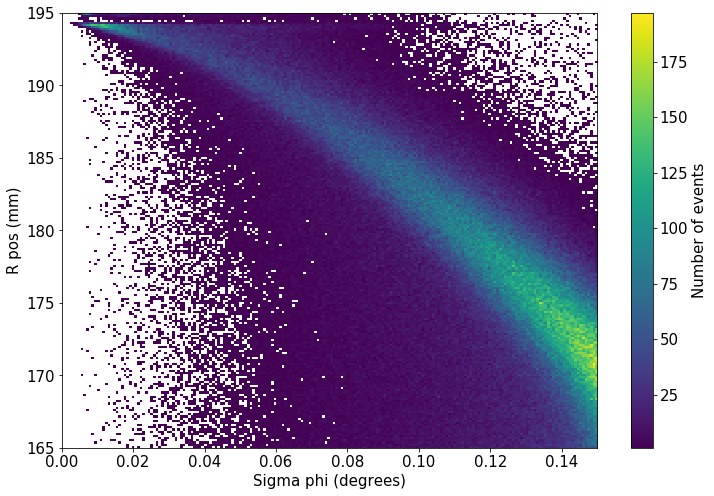

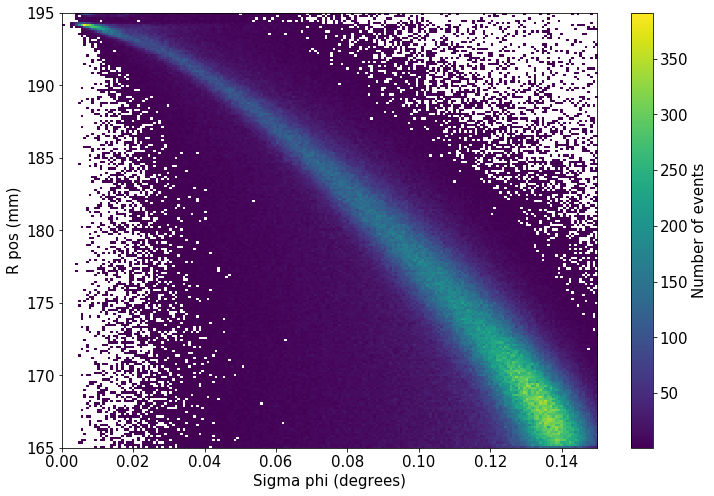

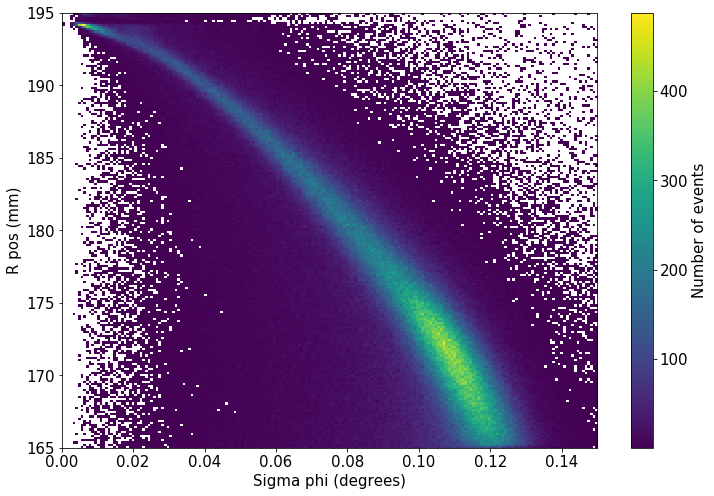

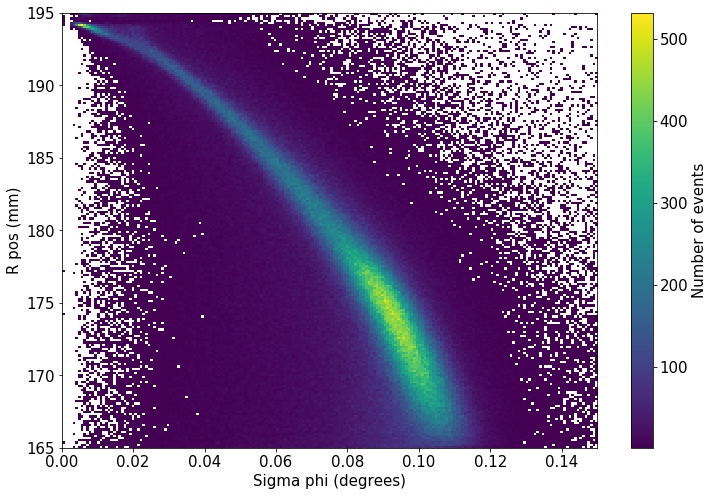

In [10]:
radii       = [[] for i in range(0, nsteps)]
var_phis    = [[] for i in range(0, nsteps)]
sigma_phis  = [[] for i in range(0, nsteps)]

#ranges = [((0., 0.2), (165., 205.)), 
#          ((0., 0.2), (165., 205.)), 
#          ((0., 0.2), (165., 205.)), 
#          ((0., 0.2), (165., 205.)), 
#          ((0., 0.2), (165., 205.)), 
#          ((0., 0.2), (165., 205.)), 
#          ((0., 0.2), (165., 205.)), 
#          ((0., 0.2), (165., 205.)), 
#          ((0., 0.2), (165., 205.)), 
#          ((0., 0.2), (165., 205.))]

ranges = [((0., 0.15), (165., 195.)), 
          ((0., 0.15), (165., 195.)), 
          ((0., 0.15), (165., 195.)), 
          ((0., 0.15), (165., 195.)), 
          ((0., 0.15), (165., 195.)), 
          ((0., 0.15), (165., 195.)), 
          ((0., 0.15), (165., 195.)), 
          ((0., 0.15), (165., 195.)), 
          ((0., 0.15), (165., 195.)), 
          ((0., 0.15), (165., 195.))]

for v in range(0, nsteps):
    fig = plt.figure(1)
    fig.set_figwidth(8.)
    fig.set_figheight(8.)
    
    # plt.subplot(2, 3, v+1)
    bins = 200

    radius    = np.concatenate((   true_r1[v],    true_r2[v]), axis=None) 
    var_phi   = np.concatenate((  var_phi1[v],   var_phi2[v]), axis=None) 
    sigma_phi = np.concatenate((sigma_phi1[v], sigma_phi2[v]), axis=None) 
    
    radii[v]       = radius
    var_phis[v]    = var_phi
    sigma_phis[v]  = sigma_phi   
    
    h2 = hist2d(sigma_phi, radius, bins=(bins, bins), range=ranges[v], cmin=1)
    plt.xlabel('Sigma phi (degrees)')
    plt.ylabel('R pos (mm)')
    plt.colorbar().set_label("Number of events")
    #fig.savefig('radial_ratio_6mm_thr5pes.pdf')
   
    radii[v] = np.array(radii[v])
    var_phis[v] = np.array(var_phis[v])
    sigma_phis[v] = np.array(sigma_phis[v])

## Threshold = 3

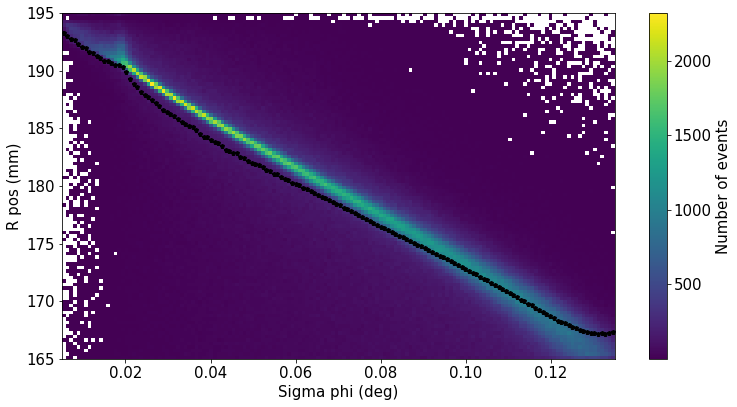

In [63]:
radlim  = 165., 195.
siglim  = 0.005, 0.135 #0., 0.15
rad     = radii     [3]
sig_phi = sigma_phis[3]

sel  = in_range(rad, *radlim) & in_range(sig_phi, *siglim)
s, r= sig_phi[sel], rad[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
Rbins = 100
Sbins = 150

plt.hist2d(s, r, (Sbins, Rbins), cmin=1)

x, y, yu = fitf.profileX(s, r, Sbins, siglim, drop_nan=False)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="kp", ms=5, lw=2)
plt.xlabel('Sigma phi (deg)')
plt.ylabel('R pos (mm)')
plt.colorbar().set_label("Number of events")
#plt.savefig('radial_ratio_thr2pes.pdf')

-233.33333333333331


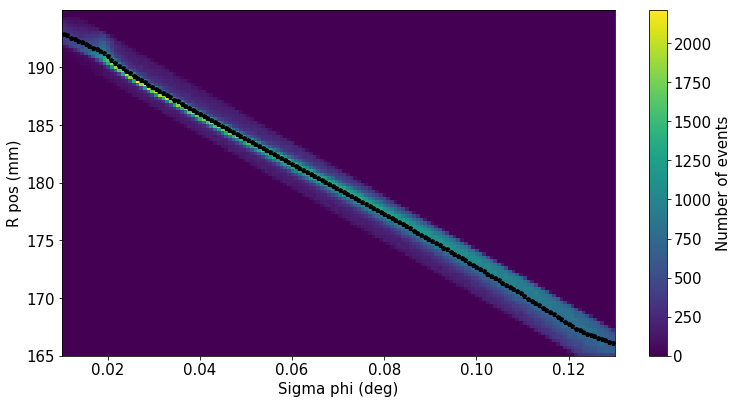

In [70]:
radlim  = 165., 195.
siglim  = 0.01, 0.13 #0., 0.15
rad     = radii     [3]
sig_phi = sigma_phis[3]

          ##wider ring
x1 = 0.01   #0.01    ###0.005
x2 = 0.13   #0.135   ###0.15
y1 = 193   #193     ###204
y2 = 165   #165     ###167

m0    = (y2 - y1)/(x2 - x1)
print(m0)
sel   = in_range(rad, *radlim) & in_range(sig_phi, *siglim)
lines = (rad > (m0 * sig_phi + 193.5)) & (rad < (m0 * sig_phi + 197.5))
s, r = sig_phi[sel & lines], rad[sel & lines]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
Rbins = 100
Sbins = 150

plt.hist2d(s, r, (Sbins, Rbins))

x, y, yu = fitf.profileX(s, r, Sbins, siglim, drop_nan=False)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="kp", ms=5, lw=2)
plt.xlabel('Sigma phi (deg)')
plt.ylabel('R pos (mm)')
plt.colorbar().set_label("Number of events")
#plt.savefig('radial_ratio_thr2pes.pdf')

## Selection of the line for the Xprofile

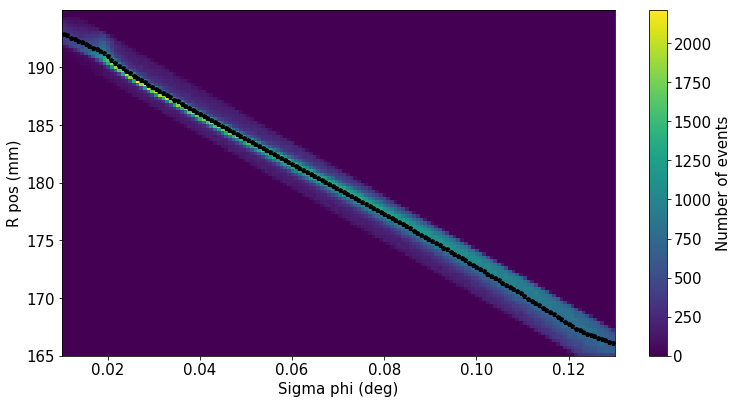

In [71]:
radlim  = 165., 195.
siglim  = 0.01, 0.13 #0., 0.15
rad     = radii     [3]
sig_phi = sigma_phis[3]

#m0    = - 209.6
sel   = in_range(rad, *radlim) & in_range(sig_phi, *siglim)
lines = (rad > (m0 * sig_phi + 193.5)) & (rad < (m0 * sig_phi + 197.5))
s, r = sig_phi[sel & lines], rad[sel & lines]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
Rbins = 100
Sbins = 150

plt.hist2d(s, r, (Sbins, Rbins))

x, y, yu = fitf.profileX(s, r, Sbins, siglim, drop_nan=False)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="kp", ms=5, lw=2)
plt.xlabel('Sigma phi (deg)')
plt.ylabel('R pos (mm)')
plt.colorbar().set_label("Number of events")
#plt.savefig('radial_ratio_thr2pes.pdf')

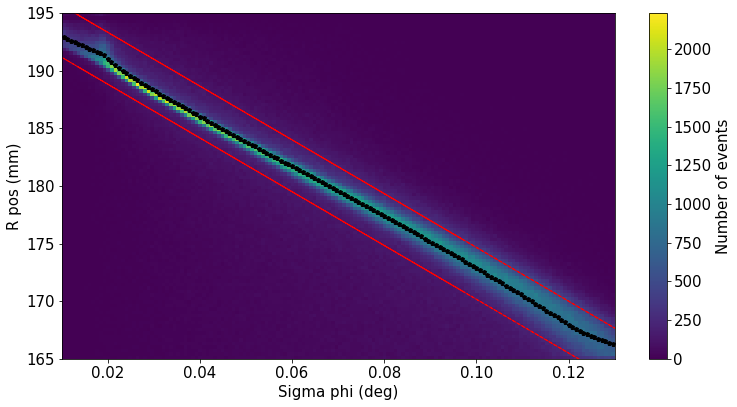

In [74]:
radlim  = 165., 195.
siglim  = 0.01, 0.13 #0., 0.15
rad     = radii     [3]
sig_phi = sigma_phis[3]

liney1 = m0 * sig_phi + 193.5
liney2 = m0 * sig_phi + 198

sel  = in_range(rad, *radlim) & in_range(sig_phi, *siglim)
s, r = sig_phi[sel], rad[sel]

frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
Rbins = 100
Sbins = 150

plt.hist2d(s, r, (Sbins, Rbins))
plt.plot(sig_phi[sel], liney1[sel], color='red', linestyle='--', linewidth=1)
plt.plot(sig_phi[sel], liney2[sel], color='red', linestyle='--', linewidth=1)

sel   = in_range(rad, *radlim) & in_range(sig_phi, *siglim)
lines = (rad > (m0 * sig_phi + 193.5)) & (rad < (m0 * sig_phi + 198))
s, r = sig_phi[sel & lines], rad[sel & lines]

x, y, yu = fitf.profileX(s, r, Sbins, siglim, drop_nan=False)
plt.errorbar(x, y, yu, np.diff(x)[0]/2, fmt="kp", ms=5, lw=2)
plt.xlabel('Sigma phi (deg)')
plt.ylabel('R pos (mm)')
plt.colorbar().set_label("Number of events")
#plt.savefig('radial_ratio_thr3pes_test.pdf')

## Table:

In [75]:
sigmanBins   = [100, 150, 200, 300]
sigmaRange   = 0.01, 0.13
sigmaBins    = {n: np.linspace(*sigmaRange, n + 1) for n in sigmanBins}
sigmaCenters = {n: shift_to_bin_centers(bins) for n, bins in sigmaBins.items()}
sigmaPitch   = {n: np.diff(bins)[0] for n, bins in sigmaBins.items()}

In [76]:
## Aquí creamos los arrays que nos servirán para la tabla

R_ave = {}
R_ave_u = {} # uncertainty

for v in range(3, 4): # Podemos no hacer el loop y poner directamente el valor del threshold que queremos
    rad     = radii[v]
    sig_phi = sigma_phis[v]
    radlim  =  165., 195.

    sel   = in_range(rad, *radlim) & in_range(sig_phi, *siglim)
    lines = (rad > (m0 * sig_phi + 193.5)) & (rad < (m0 * sig_phi + 198))
    s, r  = sig_phi[sel & lines], rad[sel & lines]

    Rbins = 300
    
    R_ave_v   = {}
    R_ave_u_v = {}

    for n in sigmaBins:
        x, y, yu     = fitf.profileX(s, r, n, sigmaRange, drop_nan=False)
        R_ave_v[  n] = y
        R_ave_u_v[n] = yu
        
    R_ave  [v] = R_ave_v
    R_ave_u[v] = R_ave_u_v

In [77]:
path = '/Users/carmenromoluque/Analysis/scripts_before_dataframes/'
phi_table_name = path+'r_sigma_phi_table_ref_walls_iradius165mm_thr3pes_depth3cm_compton_sel_photp.h5'

class Radii(tb.IsDescription):
    Sigma_phi   = tb.Float32Col(pos=0)
    Rpos        = tb.Float32Col(pos=0)
    Uncertainty = tb.Float32Col(pos=0)

with tb.open_file(phi_table_name, "w") as output_file:
    
    if '/Radius' in output_file:
        Radius = output_file.root.Radius        
    else:
        Radius = output_file.create_group(output_file.root, "Radius")
    
    for v in range(3, 4):
        for n in sigmaBins:
            pitch      = sigmaPitch[n]
            table_name = "f{0}pes{1}bins".format(v, n)

            r_table = output_file.create_table(Radius, table_name,
                                   description = Radii,
                                   title       = "radial_pos",
                                   filters     = tbl.filters('ZLIB4'))
        
        
            for i, sigma in enumerate(sigmaCenters[n], start=0):
                row = r_table.row
                row["Sigma_phi"]   = sigma
                row["Rpos"]        = R_ave[v][n][i]
                row["Uncertainty"] = R_ave_u[v][n][i] * R_ave[v][n][i] / 100
                row.append()

            table = getattr(getattr(output_file.root, 'Radius'), table_name)
            table.attrs.sigma_bins = n
            table.attrs.sigma_pitch = pitch